In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from sklearn.cluster import KMeans
from sklearn.cluster import Birch

#from unidip import UniDip
import MEArec as mr
import spikeinterface.full as si
#import LFPy
#import neuron
from spikeinterface.sortingcomponents import detect_peaks
import sklearn as sk
from sklearn.metrics import silhouette_score

# Functions

In [3]:
def files_to_list (directory = r"D:\Data_scripts\MUA_doubleshank_Neuronexus_probes\2020-12-07", filename_ending = "Rec_7_201207_132859.rhs" ):
    """returns absolute file paths (file_path) and relative file paths (file_name) of data files as list of strings
    
    Parameters
    ----------
    directory: specify the directory where files are located; must be string or converted to raw string (r'...')
    
    filename_ending:  specifiy the file ending e.g. '.npy' , 'NOT_rm.npy'
    """
    
    ####change to directory where files are located, if system can not find the path try to convert to raw string, r'....'
    os.chdir(directory)
    ####empty list for filepaths: file_path
    file_path = []
    file_name = []
    ####for loop appends filename with specific ending to file_path
    for filename in os.listdir(directory):
       if filename.endswith(filename_ending):
           ###creates absolute filepath by merging directory with filename
           file_path.append(os.path.join(directory, filename))
           file_name.append(filename)
    return file_path, file_name


def create_directory (parent_dir = '_', directory= '_'):
    """create a directory within a specified parent directory"""
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)



def artefact_removal (data1, threshold = -500, sampling_rate = 20000, x_ms_before=10, x_ms_after=10):
    """returns data (samples x channels x trials) where samples with high threshold voltage artefacts are removed.
   
        
    Parameters
    ----------
    data: input array, numpy array (samples x channels x trials)
    
    threshold: default = -500;  samples with values below this threshold are set to zero 
    
    sampling_rate: default = 20000, the sampling rate of the data
    
    x_ms_before: default = 10; sets values to 0 -->  x_ms before threshold values 
    
    x_ms_after: default = 10; 
    """
        
    
        
    x_samples_before = int(x_ms_before * sampling_rate/1000)
    x_samples_after  = int(x_ms_after  * sampling_rate/1000)
        
    
   ##### PERFORMS REJECTIONS AND CONSERVES channels 
   ###Identifies only those samples having values below threshold 
   
    #create empty array of shape mean_rms_post for appending channels: a1
    above_thr = np.zeros(np.shape(data1))
   
      
   #loop over samples:
    
    for i in range (np.size(data1, axis = 0)):
 
         if threshold > 0:        
 
             #rms values samller than threshold are appended as True to a1 array (larger values as False)
             above_thr[i, :, :] = (data1[i,:,:]) > (threshold)
                 #data[i,ch,sw] = 0  
         elif threshold <= 0:
             above_thr[i, :, :] = (data1[i,:,:]) < (threshold)
    
    #find chanel indices where below==True: channels_find
    sample_where, channel_where, trial_where  = np.where(above_thr ==True)
    
    
    ###loop over samples, channels and trials where "below_thr ==True" and set values to 0
    for samp, ch, sw in zip(sample_where, channel_where, trial_where):
        data1[samp - x_samples_before: samp + x_samples_after , ch, sw] = 0   

    
    return  data1
                     
    







#####################################################################
####################create a raterplot, showing spiketimestamps around stimulation (red line) for each sweep/stimulation
########savefig from function: https://stackoverflow.com/questions/24791709/save-a-plot-resulting-from-a-function-matplotlib-python
def rasterplot (data, t_abs = None, tf =None, sampling_rate=20000, channel_idx = 0, channel_nbr= None, time_pre_stim=-2, time_post_stim=2, save_to_path = r'_', new_file_ending= '_', save_fig = True):
    """returns timestamps of detected multi-units (samples x sweeps) and creates a rasterplot, showing spiketimestamps around stimulation (red line) for each sweep/stimulation
    
    Parameters
    ----------
    data: n-d array containing filtered raw data (samples x channels x sweeps)
    
    t_abs: absolute threshold, e.g. -70 (uV), if t_abs is specified this threshold will be used for mua detection; If t_abs=None the threshold is calculated by a treshold factor (tf) dependent on the std of the noise

    tf: threshold factor, sets MUA detection threshold by multiplication with standard deviation of baseline noise. A high tf means higher MUA detection threshold (more negative by default as tf is multiplied with -1).
    
    sampling_rate: by default = 20000 samples/s (sampling rate of input data). Converts length of sweeps in samples to time.
    
    channel_idx: channel to process/display based on corresponding index in data, check channels and corresponding indices in "channels_good_indices" array
    
    channel_nbr: the figure title and figure name is saved according to this number; the channel number according to the Intan (DAQ) channel number; --> specified in channels_good after visual inspection 
    
    sweeps: number of sweeps to display, by default all sweeps
    
    time_pre_stim: time to display before stim, default = 2 [s]
    
    time_post_stim: time to display after stim, default = 2 [s]
    
    save_to_path = file_path for saving raw data traces, provide as raw string e.g. r'.....'
    
    new_file_ending: provide string to save as new figure when function is called again and one of function paramters was changed (e.g. x_start)

    save_fig: if True, figure is saved and plot closed; if False, plot remains open for visual inspection, and figure is not saved 
       
    
        
    """
       
    
    #parameters for testing
    #channel_idx = 6
    #tf = 6
    #sweeps= np.size(data, axis =2)
    #sampling_rate=20000
    #time_pre_stim=-3
    #time_post_stim=3
    
    
    ####Parametes for plotting
    
    ####get length of sweep in samples: samples
    samples = np.size(data, axis = 0)
    ####convert length of samples-1 (subtract -1 to get even number of samples to get start sample): time
    time = (samples-1)/sampling_rate
    ####divide time by 2 for specifying time before and after stimulation: time_div
    time_div = time/2
    
    ###find number of sweeps:
    sweeps = np.size(data, axis = 2)

    
    
    if t_abs == None:        
    
        ####calculate threshold for detecting MUAs, defined by std() and tf scaling factor: thresh (sweeps)
        thresh = np.std(data[:55000, channel_idx, :], axis =0)*(-tf)
        
    else:
        ###threshold for detecting MUAs, defined by absolute threshold passed asargument: thresh0
        thresh0 = t_abs
        ###make array with repeated entries of t_abs for looping over sweeps: thresh
        thresh = np.tile(thresh0, sweeps)
    
    
    
    #initiate MUA timestamps array: rasterplot_sweep (samples x sweeps)
    rasterplot_sweep = np.zeros((np.size(data, axis = 0), np.size(data, axis = 2)), dtype='int')
    rasterplot_sweep_lst = []
    rasterplot_sweep_lst1 = []
    #loop over channels and sweeps
    
    
       
    for sweep_idx in range (sweeps):
         
  #### detect multi-units units around stimulation: x
        x = np.where(data[:,channel_idx, sweep_idx] < thresh[sweep_idx])[0]      
         
         
          
        ######select min value among detected values crossing threshold  
        
        #create empty lists for appending time stamps: stamp_min_all, lst = [] 
        stamp_min_all =[]
        lst = []
        #t_stamp = np.zeros(np.size(data, axis =0))

        
        for i in range(len(x)-1):
             #lst = []
             if x[i+1] - x[i] ==1:
                lst.append(x[i])
   
    
    
            ###minimum of several negative values for one spike
                
             elif x[i+1] - x[i] > 1:
                 lst.append(x[i])
                 stamp = np.argmin(data[lst[0]:lst[-1]+1, channel_idx, sweep_idx], axis = 0)
           
                 stamp = lst[stamp]
                 stamp_min_all.append(stamp)
                 lst =[]
            
             #elif x[i+1] - x[i] > 1 and (len(lst) <= 1):               
                 #stamp_min_all.append(x[i])                    
                
    
        
        ####append last spike from lst:stamp_min_all
        
        if (len(lst) > 1):
            stamp = np.argmin(data[lst[0]:lst[-1]+1, channel_idx, sweep_idx], axis = 0)
           
            stamp = lst[stamp]
            stamp_min_all.append(stamp)
        
        elif (len(lst) == 1):
            stamp_min_all.append(lst[0])
           
        
        #elif x[-1] - x[-2] >1 and (len(x)>1):
            #stamp_min_all.append(x[-1])
            
        elif len(x) ==1:
            stamp_min_all.append(x[0])
            
        elif len(lst) == 0 and len(x) > 0:
            stamp_min_all.append(x[-1])                         
        
        ###append stamp_min_all to  list for every sweep: rasterplot_sweep_lst
        rasterplot_sweep_lst.append(stamp_min_all)
        
                
        
    ###append timestamps of each sweep  to array containing all sweeps and spike timestamps set to 1: rasterplot_sweep (samples x sweeps)                
    for sweep in range (len(rasterplot_sweep_lst)):
    
        for stamp1 in rasterplot_sweep_lst[sweep]:
                            
            rasterplot_sweep[stamp1,sweep] = 1
    #stamp_min_all = []
    
   
    for sweep in range (len(rasterplot_sweep_lst)):
                   
    ###find non-zero indices of rasterplot_sweep and convert to time stamps [in s] before and after stimulation: rasterplot_in_s 
        rasterplot_in_s =np.flatnonzero(rasterplot_sweep[:, sweep])/(sampling_rate)-time_div  
        rasterplot_sweep_lst1.append(rasterplot_in_s.tolist())
 
    ###make rasterplot 
    sns.set()      
    plt.figure(figsize=(12,7))
    plt.eventplot(rasterplot_sweep_lst1)
    plt.axis([time_pre_stim, time_post_stim, -1, np.size(data, axis =2)+1])
    plt.axvline(x = 0, linewidth=2, color='red', linestyle='--')
    plt.xlabel("Time(s)", fontsize =22)
    plt.ylabel("Sweep #", fontsize =22 )
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)
    #plt.margins(0.05)
    
    #title for recordings: 
    plt.title("Effects of PCI-Stimulation on spike output (multi-units), \n " + str(np.size(data, axis =2))+ " sweeps, ch" + str(channel_nbr)+ ", tf " + str(tf) + ', t-abs:' + str(t_abs) + 'uV', fontsize=22)

    if save_fig == True:
        plt.savefig(save_to_path + fname +new_file_ending + "_ch" + str(channel_nbr) + "_tf " + str(tf) + '_t-abs' + str(t_abs) + 'uV' +  "_.rhs.png",dpi=300, format="PNG")
        plt.close ()  
        
    else:
        plt.show()   
             
    return rasterplot_sweep



def get_waveform(data, timestamps, samples_before= 20, samples_after=50, ch=6):
    """

    returns spike waveforms of input data aligned at peak of spike for all trials
    -------
    data: arr (samples x channels x trials), the filtered spike data

    timestamps: the timestamps returned by rasterplot function (samples x trials)
    
    samples_before: number of samples extracted before peak
    
    samples_after: number of samples extracted after peak
    """
    
    
    #for testing, delete afterwards
    #data=recording_
    #timestamps = stamps_
    #samples_before= 40 
    #samples_after= 90 
    #ch=4
    
    
    waveform_lst=[] #empty list for appending waveforms
    
    for sweep in range(np.size(data, axis=2)):
        
        #get nonzero timestamps (the spikes) for each sweep
        stamps = np.where(timestamps[:,sweep]==1)[0]             
        
        #only get stamps >= 0 after subracting samples_before 
        bool_before = stamps - samples_before >= 0                                
        #only get stamps <= 0 after subracting samples_before 
        bool_after = stamps + samples_after <= len(rasterplotsweep)               
        
        #insert True of bool_after into bool_before
        after_ind = np.where(bool_after==False)[0]
        
        #if after_ind is empty use bool_before for indexing stamps
        if after_ind.size == 0:
            stamps = stamps[bool_before]
        #if after_ind is not empty replace True of bool_before with False at after_ind 
        else: 
            bool_before[after_ind] = False
            stamps = stamps[bool_before]
        
        
        
        waveform = np.empty((1, samples_before + samples_after))   #create empty array with shape (1, samples_before + samples_after): waveform 
        
        for stamp in stamps:                                       #....and loop over stamps
            waveform = np.append(waveform, data[stamp-samples_before: stamp+samples_after, ch, sweep].reshape(1,samples_before + samples_after), axis =0)
        #delete first row which does not contain a waveform
        waveform= np.delete(waveform, 0, axis=0)
        waveform_lst.append(waveform) 
    return waveform_lst
 

def get_waveform_mearec(data, timestamps, samples_before= 20, samples_after=50, ch=6):
    """

    returns spike waveforms of input data aligned at peak of spike for all trials
    -------
    data: arr (samples x channels x trials), the filtered spike data

    timestamps: the timestamps of detected spikes (1-D array)
    
    samples_before: number of samples extracted before peak
    
    samples_after: number of samples extracted after peak
    """
    
    
    #for testing, delete afterwards
    #data=recording_
    #timestamps = stamps_
    #samples_before= 40 
    #samples_after= 90 
    #ch=4
    
    
    waveform_lst=[] #empty list for appending waveforms
        
    waveform = np.empty((1, samples_before + samples_after))   #create empty array with shape (1, samples_before + samples_after): waveform 
        
    for stamp in timestamps:                                       #....and loop over stamps
        waveform = np.append(waveform, data[stamp-samples_before: stamp+samples_after, ch, 0].reshape(1,samples_before + samples_after), axis =0)
    #delete first row which does not contain a waveform
    waveform= np.delete(waveform, 0, axis=0)
    waveform_lst.append(waveform) 
    return waveform_lst
 
        


def plot_data_for_one_sweep(data, sweep_idx = 0, channel_idx = 9, t_abs = None , tf =None, sampling_rate=20000, time_pre_stim=2, time_post_stim=2, save_to_path = r'_', new_file_ending= '_', save_fig = True):
    """
    plot 1 sweep after stimulation, to check if detected multi-units overlap with raw data  filtered, data around stimulation.#####
    
    Parameters
    ----------
        
    data: n-d array containing filtered raw data 
    
    sweep_idx: sweep index to display
    
    channel_idx: channel index to display, check channels and corresponding indices in "ch_retained" list
        
    t_abs: absolute threshold, e.g. -70 (uV), if t_abs is specified this threshold will be used for mua detection; If t_abs=None the threshold is calculated by a treshold factor (tf) dependent on the std of the noise
    
    tf: threshold factor, sets MUA detection threshold by multiplication with standard deviation of baseline noise. A high tf means higher MUA detection threshold (more negative by default as tf is multiplied with -1).
    
    sampling_rate: by default = 20000 samples/s. Converts length of sweep in samples to time.
    
    time_pre_stim: time to display before stim, default = 2 [s]
    
    time_post_stim: time to display after stim, default = 2 [s]
    
    save_to_path = file_path for saving raw data traces, provide as raw string e.g. r'.....'
    
    new_file_ending: provide string to save as new figure when function is called again and one of function paramters was changed (e.g. x_start)

    save_fig: if True, figure is saved and plot closed; if False, plot remains open for visual inspection, and figure is not saved
    
    """ 
    
    #global x, lst, stamp_min_all, stamp, t_stamp
    
    ####Parametes for plotting
    
    ####get length of sweep in samples: samples
    samples = np.size(data, axis = 0)
    ####convert length of samples-1 (subtract -1 to get even number of samples to get start sample): time
    time = (samples-1)/sampling_rate
    ####divide time by 2 for specifying time before and after stimulation: time_div
    time_div = time/2
    
    
    ####plot filtered raw data
       
    timedata = np.linspace(-(time_div),time_div, num = np.size(data, axis = 0)) 
    
    fig = plt.figure(1, figsize=(12,7))
    ax = fig.add_subplot(1,1,1)
    trace = data[:,channel_idx, sweep_idx]
    #ax.plot(timedata, trace)
    ax.plot(trace)

    ####adds a vertica line at time 0, marking the stimulation
    #ax.axvline(linewidth=1, color='red', linestyle='--')
    #mark stop off-period
    #ax.axvline(0.09,linewidth=1, color='black', linestyle='--')
    #mark stop of phase locked timewindow
    #ax.axvline(0.3,linewidth=1, color='black', linestyle='--')

    if t_abs == None:        
    
        ####calculate threshold for detecting MUAs, defined by std() and tf scaling factor: thresh1 
        thresh1 = np.std(data[:55000, channel_idx, sweep_idx])*(-tf)
        
    else:
        ####threshold for detecting MUAs, defined by absolute threshold passed asargument: thresh1
        thresh1 = t_abs

        
    ####adds a horizontal line to display MUA threshold
    ax.axhline(thresh1,linewidth=1, color='black', linestyle='--')
    
    #### detect multi-units units around stimulation: x
    x = np.where(data[:,channel_idx, sweep_idx] < thresh1)[0]
    t_stamp = np.zeros(np.size(data, axis =0), dtype=int)
   
    
   ######select min value among detected values crossing threshold  
   
    
    stamp_min_all =[]
    lst = []
    for i in range(len(x)-1):
        #lst = []
        if x[i+1] - x[i] ==1:
           lst.append(x[i])
          
           
           
        ###minimum of several negative values for one spike
    
        elif x[i+1] - x[i] > 1:
            lst.append(x[i])
           
            stamp = np.argmin(data[lst[0]:lst[-1]+1, channel_idx, sweep_idx], axis = 0)
           
            stamp = lst[stamp]
            stamp_min_all.append(stamp)
            lst = []
            
        #elif x[i+1] - x[i] > 1 and len(lst) <= 1:
                      
            
            #stamp_min_all.append(x[i])
            #lst = []
            
        
          
         
        
            

    
    ####append last spike from lst:stamp_min_all
    
    if (len(lst) > 1):
        stamp = np.argmin(data[lst[0]:lst[-1]+1, channel_idx, sweep_idx], axis = 0)
       
        stamp = lst[stamp]
        stamp_min_all.append(stamp)
    
    elif (len(lst) == 1):
        stamp_min_all.append(lst[0])
   
    
    #elif x[-1] - x[-2] >1 and (len(x)>1):
        #stamp_min_all.append(x[-1])
        
    elif len(x) ==1:
        stamp_min_all.append(x[0])
        
    elif len(lst) == 0 and len(x) > 0:
        stamp_min_all.append(x[-1])
                
                 
    for i in stamp_min_all:         
        t_stamp[i] = 1
        
    
    #t_tresh = []
    #for i in x:
       # t_tresh.append(np.argmin(data[i:i+30,channel_idx, sweep_idx], axis = 0) + i)
    
            
    
       
    
    #spiketimestamps_60_new = np.copy(spiketimestamps_all_array[sweep_idx])
    #spiketimestamps_60_new = spiketimestamps_60_new.astype(int)
    t_stamp = np.where(t_stamp ==1,120,t_stamp)
    t_stamp_peak= np.where(t_stamp==120)[0]
    #timedata_peak =timedata[t_stamp_peak]
    #ax.scatter(timedata_peak,np.ones(len(timedata_peak))*120, marker="|", color = 'blue', s=100)
    ax.scatter(t_stamp_peak,np.ones(len(t_stamp_peak))*120, marker="|", color = 'blue', s=100)

    #ax.set_title("Effects of PCI-Stimulation on spike output (multi-units), at sweep " + str(sweep_idx)+ ", ch" + str(ch_retained[channel_idx]) + ', t-abs:' + str(t_abs) + 'uV' + ', tf:' + str(tf) +"\n"  + fname, fontsize=18)
    #ax.set_xlabel("Time(s)", fontsize=22)
    #ax.axis([-(time_pre_stim),time_post_stim,-350,150])
    ax.set_ylabel("uV", fontsize=22)   
    ax.set_xlabel("Samples")
    ax.set_title("Spiketrain")

    ax.tick_params(labelsize=22)
    
    if save_fig == True:
        plt.savefig(save_to_path + new_file_ending + "ch" +str(ch_retained[channel_idx]) +"_sweep"+ str(sweep_idx)+ "_t abs " + str(t_abs) + 'uV_' + "_tf" + str(tf) +'__' + fname + "_.rhs.tiff", format="TIFF", dpi= 400)
        plt.close()   
        
    else:
        plt.show()      
   
   
def find_index_array_match (arr1, arr2):
    """returns array containing indices of array1, where array1 == array2
    
    Parameters
    ----------
    arr1   :   input numpy array 1 (1-D)  
    arr2  :    input numpy array 2 (1-D) 
    
    """
    
    ##empty list for appending indices: lst
    lst =[]
    ###loop over arr2    
    for i in arr2:
        #find indices of array1 where array1 == array2: index
        index = np.where(arr1 == i)[0][0]
        lst.append(index)
    return lst
    

def k_means(data, num_clus=3, steps=200):
    
    #data = pca_result
    #num_clus=3
    #steps=200

    # Convert data to Numpy array
    cluster_data = np.array(data)

    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))

            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())

    return cluster, center_init, distance

def get_height_width (arr1):
    """
    

    Parameters
    ----------
    arr1 : input array (spikes x samples), containing spike waveforms 

    Returns
    height and duration of trough to peak (in samples) of detected spikes for all spikes (spikes x samples)
    
    """
    #for testing, delete afterwards
    #arr1 = wve_arr_con
    #get trough of spike, i.e. its minimum
    trough = np.min(arr1, axis=1)
    #get index of trough
    ix_t = np.argmin(arr1[0])
    #get peak (maximum) following trough
    peak = np.max(arr1[:,ix_t:], axis=1)
    #get index of peak starting from trough, which is the duration of trough to peak (in samples):width
    width = np.argmax(arr1[:,ix_t:], axis=1)
    #get height by subtracting trough-peak
    height= trough-peak
    return height, width

def ecdf(arr1):
    """
    
     Parameters
     ----------
     arr1 : input array (1-D)
     Returns
     -------
     emperical cumulative density function of input array """ 

    #sort  array: x1
    x1 = np.sort(arr1)
    #arange values from 0 to 1 : y1, y2
    y1 = np.arange(1, len(x1)+1)/len(x1)
    
    return x1, y1



### Parameters 

In [4]:
#change to directory where mearec is located
os.chdir('C:/Users/hoenigsperger/mearec')


In [6]:
#enter code for generating marec templates from jupyter

mr.load_templates(r'C:\Users\hoenigsperger\mearec\tempgen1.h5')
recording_params = mr.get_default_recordings_params()
print(recording_params)
recording_params['spiketrains']['n_exc']=15
recording_params['spiketrains']['duration']=100

recording_params['spiketrains']['n_inh']=5

recording_params['spiketrains']['duration']
recording_params['recordings']['noise_level']=2

recording_params['seeds']['spiketrains']=0

recording_params['recordings']['noise_level']=2
recording_params['recordings']['n_burst_spikes']=0

recording_params['seeds']['templates']=1

recording_params['filter_cutoff']=[300,6000]
recording_params['seeds']['convolution']=3

recgen = mr.gen_recordings(params= recording_params, templates= r'C:\Users\hoenigsperger\mearec\tempgen1.h5')

mr.save_recording_generator(recgen, r'C:\Users\hoenigsperger\mearec/recgen2_noise_2uV_n_exc_15_duration_100_cutoff6000.h5')

{'spiketrains': {'n_exc': 7, 'n_inh': 3, 'f_exc': 5, 'f_inh': 15, 'st_exc': 1, 'st_inh': 3, 'min_rate': 0.5, 'ref_per': 2, 'process': 'poisson', 'gamma_shape': 2, 't_start': 0, 'duration': 10}, 'cell_types': {'excitatory': ['PC', 'SS', 'SP'], 'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']}, 'seeds': {'spiketrains': None, 'templates': None, 'convolution': None, 'noise': None}, 'templates': {'min_dist': 25, 'min_amp': 50, 'max_amp': 300, 'n_overlap_pairs': None, 'xlim': None, 'ylim': None, 'zlim': None, 'overlap_threshold': 0.9, 'n_jitters': 10, 'upsample': 8, 'pad_len': [3, 3]}, 'recordings': {'fs': None, 'dtype': 'float32', 'overlap': False, 'extract_waveforms': False, 'sync_rate': None, 'sync_jitt': 1, 'chunk_duration': 0, 'modulation': 'electrode', 'sdrand': 0.05, 'bursting': False, 'bursting_units': None, 'exp_decay': 0.2, 'n_burst_spikes': 10, 'max_burst_duration': 100, 'shape_mod': False, 'shape_stretch': 30.0, 'n_bursting': None, 'noise_level': 10, 'noise_mode

In [7]:
# load SI objects
recording, sorting = si.read_mearec(r'C:\Users\hoenigsperger\mearec/recgen2_noise_2uV_n_exc_15_duration_100_cutoff6000.h5')
s_rate = recording.get_sampling_frequency()
# get all spikes and labels as np.array, all spikes contain spikes from all channels concatenated in 1-D array
all_spikes, all_labels = sorting.get_all_spike_trains()[0]
# the [0] is to select the first (and only) segment
recording_ = recording.get_traces()
#add axis to make compatible with existing rstaerplot function
recording_ = np.expand_dims(recording_, axis=2)
time = recording.get_times()
time_= time/s_rate

In [8]:
print(s_rate)
print(time[0])
print(time[-1])


32000.0
0.0
99.99996875


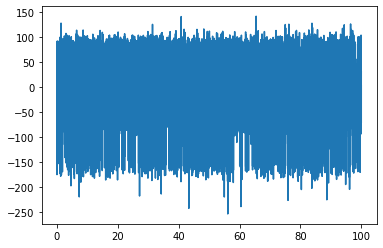

In [9]:
#channel to plot
ch_ = 6
plt.plot(time[:], recording_[:,ch_])


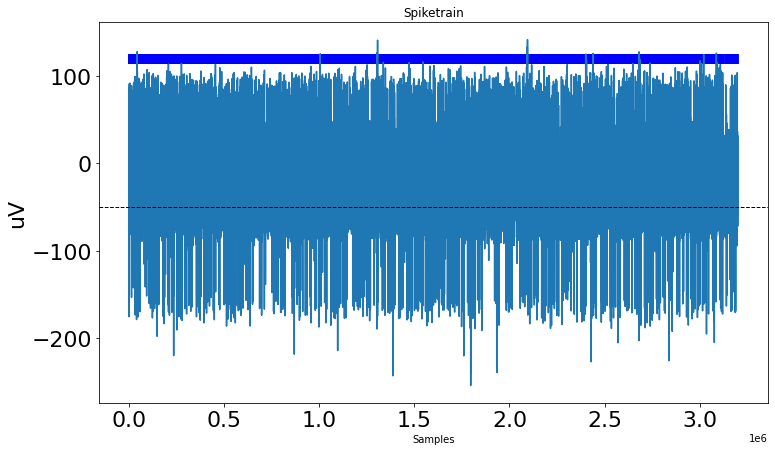

In [10]:
####inspect one of single sweeps visually and find good channels and thresholds:
#plot_data_for_one_sweep(data, sweep_idx =39, channel_idx =21, t_abs= -50, tf = None, sampling_rate=s_rate, time_pre_stim=0.2, time_post_stim=0.6, save_to_path=r'D:/Data_scripts/MUA_doubleshank_Neuronexus_probes/' + directory + '/analysis/mua/mua_sweep/', new_file_ending='_mua_wake_400dpi', save_fig=True)
plot_data_for_one_sweep(recording_, sweep_idx =0, channel_idx = ch_, t_abs= -50, tf = None, sampling_rate=32000, time_pre_stim=50, time_post_stim=50, save_to_path=r'', new_file_ending='_mua_',  save_fig=False)


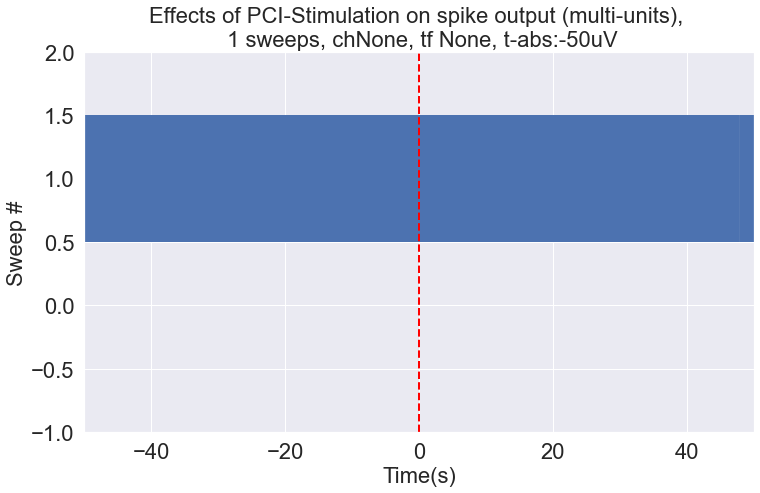

In [12]:
#%%
###################################plot rasterplot and get timestamps across all trials for one channel###################################


####inspect rasterplot and compare with plot_data_for_one_sweep_function, do timestamps of both functions overlap?:
rasterplotsweep = rasterplot(recording_, t_abs=-50 ,tf =None, sampling_rate=32000, channel_idx = ch_, time_pre_stim=-50, time_post_stim=50, save_to_path =  r'_', save_fig = False)
#get timestamps of rasterplotsweep
rasterplotsweep_ = np.nonzero(rasterplotsweep)[0]
#discard 1st and last spikes
rasterplotsweep_ = rasterplotsweep_[1:-1]

rasterplotsweep_s = rasterplotsweep_/32000

#use detect_peaks from spikeinterface to get timestamps
peaks = detect_peaks(recording)



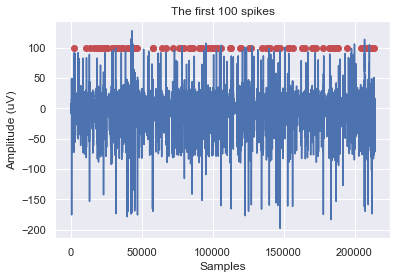

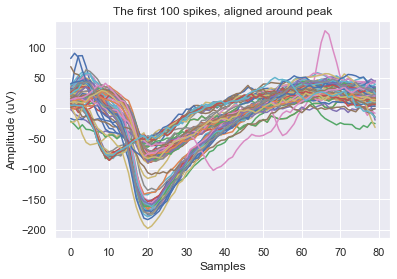

In [21]:
#%%

##################################select spikes and get waveforms#################################

#check where timestamps in rasterplots match timestramps in all_spikes
ix = []
for i in all_spikes:
    ix.append(np.where(rasterplotsweep_ == i)[0])
#get only lists containing values,value appended if list is not empty
ix_ = np.array([i for i,x in enumerate(ix) if x.size>0])

#some peaks are shifted by +1 returned by "get_all_spike_trains()", add +1 to all_spikes and repeat step above
ix1 = []
for i in all_spikes+1:
    ix1.append(np.where(rasterplotsweep_ == i)[0])
#get only lists containing values,value appended if list is not empty
ix1_ = np.array([i for i,x in enumerate(ix1) if x.size>0])

#some peaks are shifted by -1, subtract from all_spikes and repeat step above
ix2 = []
for i in all_spikes-1:
    ix2.append(np.where(rasterplotsweep_ == i)[0])
#get only lists containing values,value appended if list is not empty
ix2_ = np.array([i for i,x in enumerate(ix2) if x.size>0])



#concatenate ix_ ix1_ and ix2_ and sort array
ix_conc = np.sort(np.concatenate((ix_, ix1_, ix2_)))


#add 2nd axis to stamps_ before passing to get_waveform
stamps_ =all_spikes[ix_conc]
#labels
labels_ = all_labels[ix_conc]

#plot first 100 stamps
ix100 = stamps_[100] #index of 100th stamp

plt.plot(recording_[:ix100, ch_])
plt.scatter(stamps_[:100], np.ones(100)*100, c='r')
plt.xlabel("Samples")
plt.ylabel("Amplitude (uV)")
plt.title("The first 100 spikes")


#remove # from labels
labels_rem = [int(i[1:]) for i in labels_]

#get waveforms of slected spikes
wve = get_waveform_mearec(recording_,stamps_, samples_before=20, samples_after=60, ch=ch_)[0]

#Next we want to investigate the shape of detected spikes.
#Lets plot the first 100 spikes of the first trial on top of each other.
plt.figure()  
for i in range(100):    
    _= plt.plot(wve[i,:], '-')
plt.xlabel("Samples")
plt.ylabel("Amplitude (uV)")
plt.title("The first 100 spikes, aligned around peak")
plt.show()

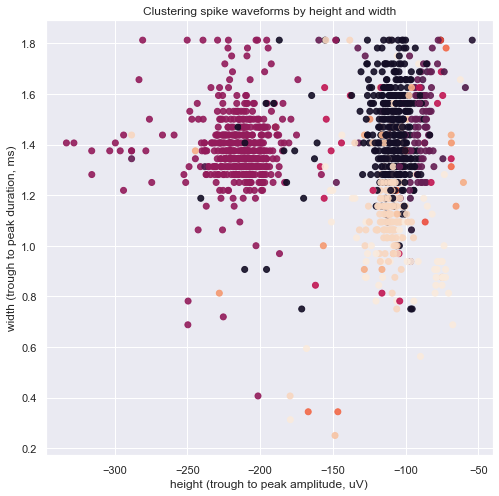

In [26]:

##########cluster waveforms by height and width##############

height, width = get_height_width(wve)

#convert width in samples to width in ms
width_ms = (width/s_rate)*1000
plt.figure(figsize=(8, 8))
_= plt.scatter(height, width_ms, alpha=0.9, c=labels_rem)
_= plt.xlabel('height (trough to peak amplitude, uV)')
_= plt.ylabel('width (trough to peak duration, ms)')
_= plt.title ('Clustering spike waveforms by height and width')
plt.show()


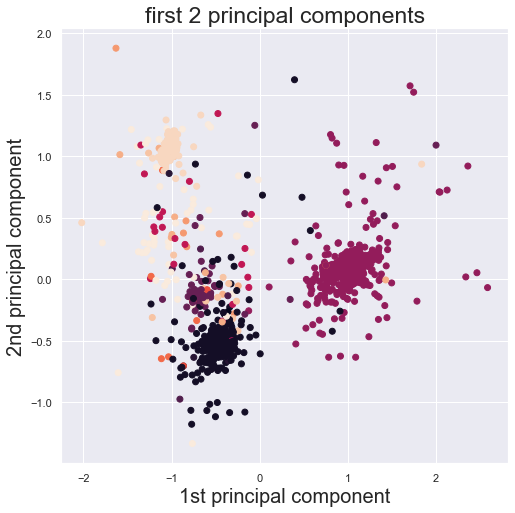

In [23]:
########MinMaxScaler_pca_kmeans##############


# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wve)

# Do PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(dataset_scaled)

#plot pca result
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_rem)
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 2 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

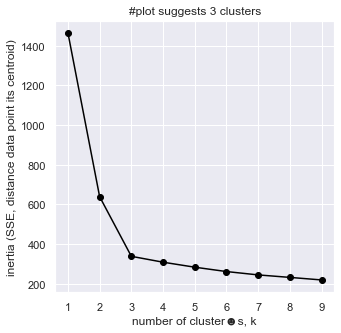

In [33]:
#%%
#evaluate the number of clusters using the elbow method, the inertia is corresponding to the sum of squared errors, by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. (euclidean distance centroid from datapoints)  
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_result[:,:])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
plt.figure(figsize=(5,5))    
_=plt.plot(ks, inertias, '-o', color='black')
_=plt.xlabel('number of cluster☻s, k')
_=plt.ylabel('inertia (SSE, distance data point its centroid)')
_=plt.xticks(ks)
plt.title("#plot suggests 3 clusters")
plt.show()
#plot suggests 3 clusters


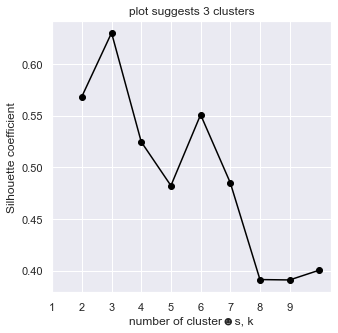

In [36]:
#evaluate the number of clusters using the silhouette method, 
#The silhouette coefficient is a measure of cluster cohesion and separation.
#It quantifies how well a data point fits into its assigned cluster based on two factors:
#How close the data point is to other points in the cluster
#How far away the data point is from points in other clusters

#Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_result[:,:])
    score = silhouette_score(pca_result[:,:], kmeans.labels_)
    silhouette_coefficients.append(score)
plt.figure(figsize=(5,5))  
_=plt.plot(range(2, 11), silhouette_coefficients, '-o', color='black')
_=plt.xlabel('number of cluster☻s, k')
_=plt.xticks(range(2,11))
_=plt.ylabel('Silhouette coefficient')
_=plt.xticks(ks)
plt.title("plot suggests 3 clusters")
plt.show()
#plot suggests 3 clusters

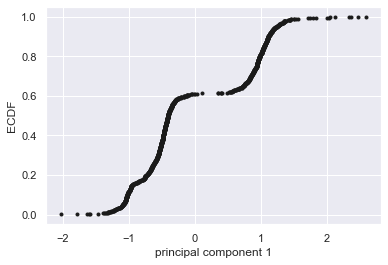

In [37]:
#another way to check how many clusters are present in our data is to plot the ecdf (empirical cumulative density function)
#let's check the ecdf of for the height parameter first
x,y = ecdf(pca_result[:,0])
plt.figure() 
_ = plt.plot(x,y, '.', color='k')
_ = plt.xlabel('principal component 1')
_ = plt.ylabel('ECDF')
plt.show()
#it looks like there are 3 clusters


In [43]:
#use kmeans with 3 clusters based on silhouette and ecdf plots
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_result[:,:])
labels_kmean = kmeans.labels_
#compare kmeans labels with ground truth labels and compute ari score
#adjusted rand index (ARI). Unlike the silhouette coefficient, 
#the ARI uses true cluster assignments to measure the similarity between true and predicted labels.
#The ARI output values range between -1 and 1. A score close to 0.0 indicates random assignments, 
#and a score close to 1 indicates perfectly labeled clusters.
ari_minmax_scaler_pca_kmeans = sk.metrics.adjusted_rand_score(labels_rem, kmeans.labels_)
#compare ari with pandas crosstab function

df = pd.DataFrame(dict(labels_kmeans = kmeans.labels_, labels_true = labels_rem)) 
ct= pd.crosstab(df['labels_kmeans'], df['labels_true'])
#https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2


In [40]:
print("adjusted rand index (ARI): " + str(ari_minmax_scaler_pca_kmeans))

adjusted rand index (ARI): 0.7471976307176252


In [41]:
ct

labels_true,0,1,2,4,5,6,7,8,9,12,13,14,15,16,17,18,19
labels_kmeans,,,,,,,,,,,,,,,,,
0,0,5,1,0,4,0,0,0,12,0,1,0,5,6,2,127,42
1,0,4,0,1,2,0,471,0,0,0,0,1,0,1,0,1,0
2,2,419,2,6,71,1,2,2,8,3,4,0,2,5,10,0,19


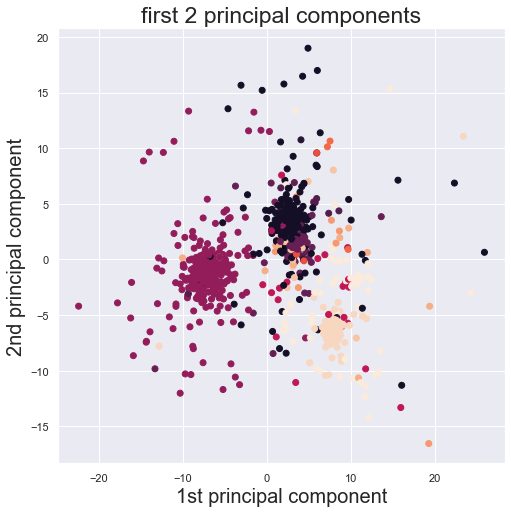

In [44]:
###########standard scaler kmeans###########


# Apply standard scaler
scaler= sk.preprocessing.StandardScaler()
dataset_scaled = scaler.fit_transform(wve)

# Do PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(dataset_scaled)

#plot pca result
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_rem)
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 2 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


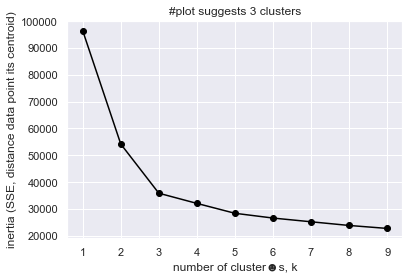

In [45]:
#evaluate the number of clusters using the elbow method, the inertia is corresponding to the sum of squared errors, by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. (euclidean distance centroid from datapoints)  
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_result[:,:])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
_=plt.plot(ks, inertias, '-o', color='black')
_=plt.xlabel('number of cluster☻s, k')
_=plt.ylabel('inertia (SSE, distance data point its centroid)')
plt.title("#plot suggests 3 clusters")
_=plt.xticks(ks)
plt.show()

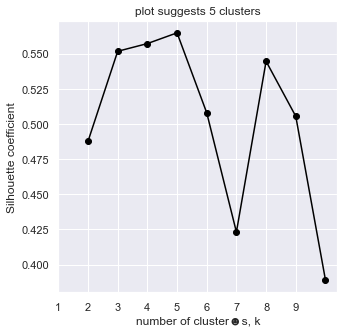

In [47]:
#evaluate the number of clusters using the silhouette method, 
#The silhouette coefficient is a measure of cluster cohesion and separation.
#It quantifies how well a data point fits into its assigned cluster based on two factors:
#How close the data point is to other points in the cluster
#How far away the data point is from points in other clusters

#Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_result[:,:])
    score = silhouette_score(pca_result[:,:], kmeans.labels_)
    silhouette_coefficients.append(score)
plt.figure(figsize=(5,5))  
_=plt.plot(range(2, 11), silhouette_coefficients, '-o', color='black')
_=plt.xlabel('number of cluster☻s, k')
_=plt.xticks(range(2,11))
_=plt.ylabel('Silhouette coefficient')
_=plt.xticks(ks)
plt.title("plot suggests 5 clusters")
plt.show()
#plot suggests 5 clusters

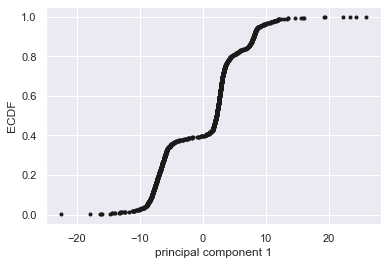

In [48]:
#another way to check how many clusters are present in our data is to plot the ecdf (empirical cumulative density function)
#let's check the ecdf of for the height parameter first
x,y = ecdf(pca_result[:,0])
plt.figure() 
_ = plt.plot(x,y, '.', color='k')
_ = plt.xlabel('principal component 1')
_ = plt.ylabel('ECDF')
plt.show()
#it looks like there are 3 clusters


In [63]:
#use kmeans with 4 clusters based on silhouette and ecdf plots
kmeans = KMeans(n_clusters= 4)
kmeans.fit(pca_result[:,:])
labels_kmean = kmeans.labels_
#compare kmeans labels with ground truth labels and compute ari score
#adjusted rand index (ARI). Unlike the silhouette coefficient, 
#the ARI uses true cluster assignments to measure the similarity between true and predicted labels.
#The ARI output values range between -1 and 1. A score close to 0.0 indicates random assignments, 
#and a score close to 1 indicates perfectly labeled clusters.
ari_standard_scaler_pca_kmeans = sk.metrics.adjusted_rand_score(labels_rem, kmeans.labels_)
#compare ari with pandas crosstab function

df = pd.DataFrame(dict(labels_kmeans = kmeans.labels_, labels_true = labels_rem)) 
ct= pd.crosstab(df['labels_kmeans'], df['labels_true'])
#https://medium.com/more-python-less-problems/principal-compon

In [64]:
print("adjusted rand index (ARI): " + str(ari_standard_scaler_pca_kmeans))

adjusted rand index (ARI): 0.7293129187808758


In [65]:
ct

labels_true,0,1,2,4,5,6,7,8,9,12,13,14,15,16,17,18,19
labels_kmeans,,,,,,,,,,,,,,,,,
0,0,15,1,2,3,0,7,0,1,1,2,0,0,0,2,1,2
1,2,397,1,4,69,1,2,2,8,2,1,0,6,7,9,0,7
2,0,5,0,1,2,0,463,0,0,0,0,1,0,1,0,1,0
3,0,11,1,0,3,0,1,0,11,0,2,0,1,4,1,126,52
